In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from scipy.stats import mode
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

In [2]:
df = pd.read_csv("data_raw_feature.csv")
df

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_80300/4048231362.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data_raw_feature.csv")


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,angle_thumb_tip_flex_std5,vel_z_8_mean5,vel_z_8_std5,acc_z_8_mean5,acc_z_8_std5,z_8_mean5,z_8_std5,nan_count,person_id,behavior_encoded
0,1,5929,98.817,Left,1,0.591459,0.625579,0.651917,0.659749,0.667918,...,3.342751,0.002443,0.005938,-0.000139,0.007436,-0.041774,0.007476,0,user1,1
1,1,5930,98.833,Left,1,0.592415,0.626004,0.651004,0.659993,0.667155,...,2.471606,0.002459,0.005920,0.000016,0.007438,-0.039314,0.003534,0,user1,1
2,1,5931,98.850,Left,1,0.592034,0.628098,0.654261,0.666322,0.680227,...,2.026284,0.001556,0.004803,-0.000903,0.005603,-0.037758,0.002380,0,user1,1
3,1,5932,98.867,Left,1,0.591934,0.628256,0.653948,0.666119,0.679369,...,2.013474,-0.002246,0.005902,-0.003802,0.008877,-0.040004,0.004739,0,user1,1
4,1,5933,98.883,Left,1,0.593303,0.631555,0.656808,0.671773,0.687536,...,1.813541,-0.001701,0.006321,0.000545,0.011538,-0.041705,0.004380,0,user1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71176,9,11074,184.567,Right,1,0.495803,0.578942,0.635216,0.683654,0.710186,...,3.419233,-0.012091,0.044043,0.009544,0.080738,0.128145,0.037917,0,user7,2
71177,9,11075,184.583,Right,1,0.495539,0.579092,0.632622,0.684958,0.711404,...,6.942008,-0.027937,0.048491,-0.015845,0.091973,0.100209,0.045454,0,user7,2
71178,9,11076,184.600,Right,1,0.499559,0.576240,0.626404,0.678726,0.711590,...,7.737436,-0.018416,0.049216,0.009521,0.096470,0.081793,0.048409,0,user7,2
71179,9,11077,184.617,Right,1,0.504995,0.544119,0.578533,0.609012,0.625633,...,6.197763,-0.030170,0.044499,-0.011754,0.093083,0.051624,0.040781,0,user7,2


behavior_encoded     0     1     2
person_id                         
user0101          1332   960   862
user0102          2172  1992  4650
user0202          1825  1841  3507
user1             1815  5016  3670
user2             1564  1002  2746
user3              866  2428  6116
user4             1860  3174  5516
user5              303  1773  3576
user6              420  1699  3737
user7              342   620  1291
user8              178   666  1662


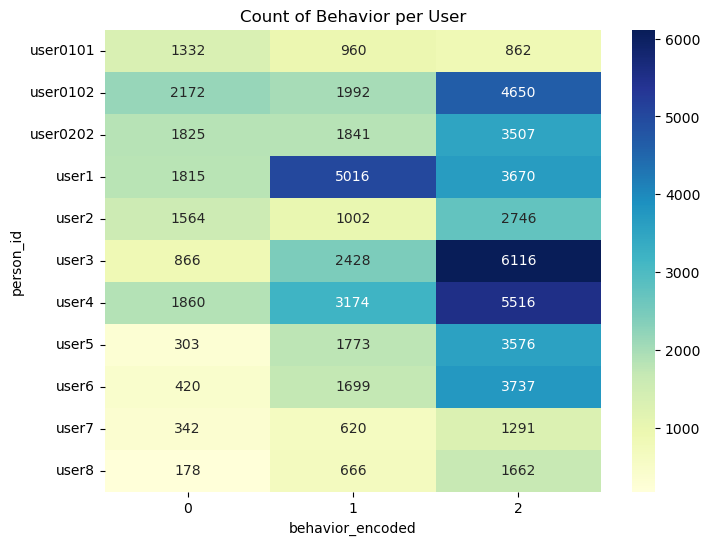

In [3]:
df_counts = df.groupby(['person_id', 'behavior_encoded']).size().unstack(fill_value=0)

print(df_counts)

plt.figure(figsize=(8, 6))
sns.heatmap(df_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Count of Behavior per User')
plt.xlabel('behavior_encoded')
plt.ylabel('person_id')
plt.show()

In [4]:
df_props = df_counts.div(df_counts.sum(axis=1), axis=0)
print(df_props.round(3))


behavior_encoded      0      1      2
person_id                            
user0101          0.422  0.304  0.273
user0102          0.246  0.226  0.528
user0202          0.254  0.257  0.489
user1             0.173  0.478  0.349
user2             0.294  0.189  0.517
user3             0.092  0.258  0.650
user4             0.176  0.301  0.523
user5             0.054  0.314  0.633
user6             0.072  0.290  0.638
user7             0.152  0.275  0.573
user8             0.071  0.266  0.663


In [5]:
user2_df = df[df['person_id'] == 'user2'].copy()

split_index = int(len(user2_df) * 0.5)

user2_first_part = user2_df.iloc[:split_index].copy()     # 40%
user2_second_part = user2_df.iloc[split_index:].copy()    # 60%

user2_first_part['person_id'] = 'user0201-1'
user2_second_part['person_id'] = 'user0201-2'

df_augmented = pd.concat([df, user2_first_part, user2_second_part], ignore_index=True)

In [6]:
df_augmented

,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,angle_thumb_tip_flex_std5,vel_z_8_mean5,vel_z_8_std5,acc_z_8_mean5,acc_z_8_std5,z_8_mean5,z_8_std5,nan_count,person_id,behavior_encoded
0,1,5929,98.817,Left,1,0.591459,0.625579,0.651917,0.659749,0.667918,...,3.342751,0.002443,0.005938,-0.000139,0.007436,-0.041774,0.007476,0,user1,1
1,1,5930,98.833,Left,1,0.592415,0.626004,0.651004,0.659993,0.667155,...,2.471606,0.002459,0.005920,0.000016,0.007438,-0.039314,0.003534,0,user1,1
2,1,5931,98.850,Left,1,0.592034,0.628098,0.654261,0.666322,0.680227,...,2.026284,0.001556,0.004803,-0.000903,0.005603,-0.037758,0.002380,0,user1,1
3,1,5932,98.867,Left,1,0.591934,0.628256,0.653948,0.666119,0.679369,...,2.013474,-0.002246,0.005902,-0.003802,0.008877,-0.040004,0.004739,0,user1,1
4,1,5933,98.883,Left,1,0.593303,0.631555,0.656808,0.671773,0.687536,...,1.813541,-0.001701,0.006321,0.000545,0.011538,-0.041705,0.004380,0,user1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76488,2,9916,165.267,Left,1,0.637879,0.640627,0.643557,0.632330,0.617943,...,0.243781,-0.001533,0.002132,-0.000862,0.002268,0.018880,0.003061,0,user0201-2,1
76489,2,9917,165.283,Left,1,0.638833,0.639916,0.642754,0.630766,0.615455,...,0.240738,-0.004358,0.006587,-0.002825,0.005427,0.014523,0.009437,0,user0201-2,1
76490,2,9918,165.300,Left,1,0.634353,0.636170,0.638883,0.624243,0.606535,...,0.281789,-0.001805,0.010388,0.002553,0.015470,0.012718,0.008744,0,user0201-2,1
76491,2,9919,165.317,Left,1,0.636474,0.636519,0.638334,0.623649,0.606568,...,0.216957,-0.002521,0.010315,-0.000716,0.017750,0.010197,0.007317,0,user0201-2,1


In [7]:
df = df_augmented

behavior_encoded     0     1     2
person_id                         
user0101          1332   960   862
user0102          2172  1992  4650
user0201-1         696   603  1357
user0201-2         868   399  1389
user0202          1825  1841  3507
user1             1815  5016  3670
user2             1564  1002  2746
user3              866  2428  6116
user4             1860  3174  5516
user5              303  1773  3576
user6              420  1699  3737
user7              342   620  1291
user8              178   666  1662


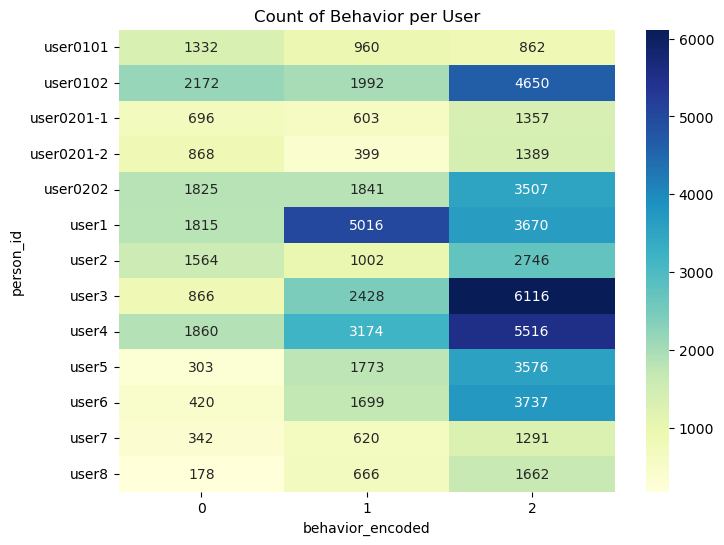

In [8]:
df_counts = df.groupby(['person_id', 'behavior_encoded']).size().unstack(fill_value=0)

print(df_counts)

plt.figure(figsize=(8, 6))
sns.heatmap(df_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Count of Behavior per User')
plt.xlabel('behavior_encoded')
plt.ylabel('person_id')
plt.show()

In [143]:
for axis in ['x', 'y', 'z']:
    base = df[f'{axis}_0']
    for i in range(21):
        df[f'{axis}_{i}'] = df[f'{axis}_{i}'] - base

### 63 features

In [144]:
xyz_cols = [f'{axis}_{i}' for axis in ['x', 'y', 'z'] for i in range(21)]

all_feature_cols = xyz_cols

### 173 features

In [144]:
xyz_cols = [f'{axis}_{i}' for axis in ['x', 'y', 'z'] for i in range(21)]
jerk_cols    = [col for col in df.columns if col.startswith('jerk_')]
angle_cols   = [col for col in df.columns if col.startswith('angle_')]
dist_cols    = [col for col in df.columns if col.startswith('dist_')]

all_feature_cols = (xyz_cols + jerk_cols + angle_cols + dist_cols)

In [145]:
all_feature_cols

['x_0',
 'x_1',
 'x_2',
 'x_3',
 'x_4',
 'x_5',
 'x_6',
 'x_7',
 'x_8',
 'x_9',
 'x_10',
 'x_11',
 'x_12',
 'x_13',
 'x_14',
 'x_15',
 'x_16',
 'x_17',
 'x_18',
 'x_19',
 'x_20',
 'y_0',
 'y_1',
 'y_2',
 'y_3',
 'y_4',
 'y_5',
 'y_6',
 'y_7',
 'y_8',
 'y_9',
 'y_10',
 'y_11',
 'y_12',
 'y_13',
 'y_14',
 'y_15',
 'y_16',
 'y_17',
 'y_18',
 'y_19',
 'y_20',
 'z_0',
 'z_1',
 'z_2',
 'z_3',
 'z_4',
 'z_5',
 'z_6',
 'z_7',
 'z_8',
 'z_9',
 'z_10',
 'z_11',
 'z_12',
 'z_13',
 'z_14',
 'z_15',
 'z_16',
 'z_17',
 'z_18',
 'z_19',
 'z_20',
 'jerk_x_0',
 'jerk_x_1',
 'jerk_x_2',
 'jerk_x_3',
 'jerk_x_4',
 'jerk_x_5',
 'jerk_x_6',
 'jerk_x_7',
 'jerk_x_8',
 'jerk_x_9',
 'jerk_x_10',
 'jerk_x_11',
 'jerk_x_12',
 'jerk_x_13',
 'jerk_x_14',
 'jerk_x_15',
 'jerk_x_16',
 'jerk_x_17',
 'jerk_x_18',
 'jerk_x_19',
 'jerk_x_20',
 'jerk_y_0',
 'jerk_y_1',
 'jerk_y_2',
 'jerk_y_3',
 'jerk_y_4',
 'jerk_y_5',
 'jerk_y_6',
 'jerk_y_7',
 'jerk_y_8',
 'jerk_y_9',
 'jerk_y_10',
 'jerk_y_11',
 'jerk_y_12',
 'jerk_

In [147]:
selected_users = ['user1', 'user3', 'user4', 'user5', 
                  'user6', 'user7', 'user2', 'user8',
                  'user0101', 'user0102', 'user0202',
                  'user2', 'user0201-1', 'user0201-2',
                  'user101'
]
df = df[df['person_id'].isin(selected_users)].copy()

In [148]:
def prepare_data(
    df,
    all_feature_cols,
    train_users,
    test_users,
    group_col='person_id',
    window_size=30,
    step=5
):
    def create_sequences_with_groups(df, feature_cols, group_col, window_size, step):
        X, y, group_seq = [], [], []
        for _, group in df.groupby(group_col):
            data = group[feature_cols].values
            labels = group['behavior_encoded'].values
            groups = group[group_col].values
            for i in range(0, len(group) - window_size + 1, step):
                X.append(data[i:i+window_size])
                dominant_label = mode(labels[i:i+window_size], keepdims=False).mode
                y.append(dominant_label)
                group_seq.append(groups[i+window_size - 1])
        return np.array(X), np.array(y), np.array(group_seq)

    X_seq, y_seq, group_seq = create_sequences_with_groups(df, all_feature_cols, group_col, window_size, step)

    train_mask = np.isin(group_seq, train_users)
    test_mask = np.isin(group_seq, test_users)

    X_train, y_train = X_seq[train_mask], y_seq[train_mask]
    X_val, y_val = X_seq[test_mask], y_seq[test_mask]

    n_t, w, f = X_train.shape
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, f)).reshape(n_t, w, f)
    X_val = scaler.transform(X_val.reshape(-1, f)).reshape(X_val.shape[0], w, f)

    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_val_cat = to_categorical(y_val, num_classes=num_classes)

    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(cw))

    return X_train, y_train, y_train_cat, X_val, y_val, y_val_cat, class_weights, num_classes